In [25]:
# imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [26]:
# Load cleaned data from eda step
file_path = "../data/cleaned_diabetes_health_indicators_dataset.csv"
df = pd.read_csv(file_path)

predictors_to_use = ["BMI", "Age", "Income", "HighBP", "HighChol", "CholCheck", "Smoker", "Stroke",
                     "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump",
                     "AnyHealthcare", "NoDocbcCost", "GenHlth", "DiffWalk", "Sex", "Education",
                     "MentHlth", "PhysHlth", "Diabetes_012"]

df = df[predictors_to_use].dropna()

In [27]:
# Standardize Data
numerical_predictor_columns = ["BMI", "Age", "Income"]

# Find Z-score of Numerical Predictors
Z_train = preprocessing.scale(df[numerical_predictor_columns])
Z_train = pd.DataFrame(Z_train, columns=numerical_predictor_columns)

# Create dummy vars
dummy_HighBP = pd.get_dummies(df["HighBP"], drop_first=True)
dummy_HighChol = pd.get_dummies(df["HighChol"], drop_first=True)
dummy_CholCheck = pd.get_dummies(df["CholCheck"], drop_first=True)
dummy_Smoker = pd.get_dummies(df["Smoker"] , drop_first=True)
dummy_Stroke = pd.get_dummies(df["Stroke"] , drop_first=True)
dummy_HeartDiseaseorAttack = pd.get_dummies(df["HeartDiseaseorAttack"] , drop_first=True)
dummy_PhysActivity = pd.get_dummies(df["PhysActivity"] , drop_first=True)
dummy_Fruits = pd.get_dummies(df["Fruits"] , drop_first=True)
dummy_Veggies = pd.get_dummies(df["Veggies"] , drop_first=True)
dummy_HvyAlcoholConsump = pd.get_dummies(df["HvyAlcoholConsump"] , drop_first=True)
dummy_AnyHealthcare = pd.get_dummies(df["AnyHealthcare"] , drop_first=True)
dummy_NoDocbcCost = pd.get_dummies(df["NoDocbcCost"] , drop_first=True)
dummy_GenHlth = pd.get_dummies(df["GenHlth"] , drop_first=True)
dummy_DiffWalk = pd.get_dummies(df["DiffWalk"] , drop_first=True)
dummy_Sex = pd.get_dummies(df["Sex"] , drop_first=True)
dummy_Education = pd.get_dummies(df["Education"] , drop_first=True)
dummy_MentHlth = pd.get_dummies(df["MentHlth"] , drop_first=True)
dummy_PhysHlth = pd.get_dummies(df["PhysHlth"] , drop_first=True)

# Concatenate the standardized numerical features with the dummy vars
X = pd.concat([Z_train, dummy_HighBP, dummy_HighChol, dummy_CholCheck, dummy_Smoker, dummy_Stroke, dummy_HeartDiseaseorAttack,
                     dummy_PhysActivity, dummy_Fruits, dummy_Veggies, dummy_HvyAlcoholConsump, dummy_AnyHealthcare, dummy_NoDocbcCost,
                    dummy_GenHlth, dummy_DiffWalk, dummy_Sex, dummy_Education], axis=1)
X.columns = X.columns.astype(str)
y = df["Diabetes_012"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Train on each class separately
mask_0 = (y_train == 0)
X_train_0 = X_train[mask_0]

mask_1 = (y_train == 1)
X_train_1 = X_train[mask_1]

mask_2 = (y_train == 2)
X_train_2 = X_train[mask_2]

# Create and fit models
ocsvm_0 = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_0.fit(X_train_0)

ocsvm_1 = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_1.fit(X_train_1)

ocsvm_2 = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_2.fit(X_train_2)

# Predict Using All Three Models
predictions = []

for idx in range(X_test.shape[0]):
    sample = X_test.iloc[idx:idx+1]

    # Compute decision function scores
    score_0 = ocsvm_0.decision_function(sample)[0]
    score_1 = ocsvm_1.decision_function(sample)[0]
    score_2 = ocsvm_2.decision_function(sample)[0]

    scores = [score_0, score_1, score_2]

    # Predict the class with the highest score
    predicted_class = np.argmax(scores)
    predictions.append(predicted_class)

# Convert predictions to array
predictions = np.array(predictions)

# Multi-Class One-Class SVM Classification Report
print("\nOne-Class SVM Multi-Class Classification Report")
print(classification_report(y_test, predictions))


One-Class SVM Multi-Class Classification Report
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     38116
         1.0       0.02      0.04      0.03       906
         2.0       0.47      0.07      0.11      6935

    accuracy                           0.80     45957
   macro avg       0.44      0.35      0.34     45957
weighted avg       0.76      0.80      0.76     45957



# Save final prediction data to results directory to be used in ensemble voting

In [29]:
# Make results directory, if it's doesn't exist
os.makedirs("results", exist_ok=True)
# Save prediction results to be later used in the ensemble voting
np.save("results/y_pred_ocsvm.npy", predictions)
# Save test data to be later used in the ensemble voting
np.save("results/y_test.npy", y_test.to_numpy())

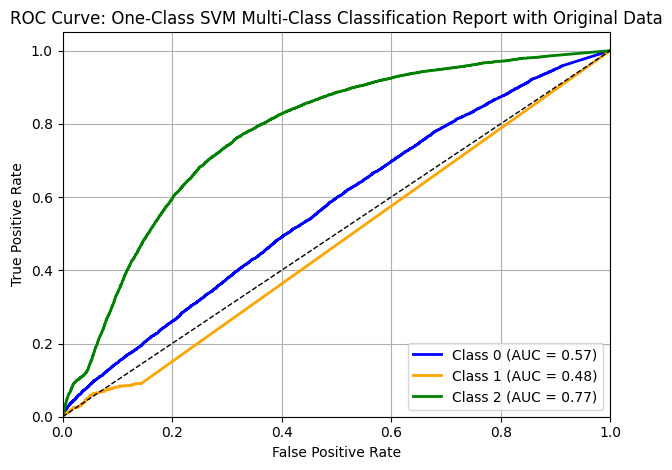

In [30]:
# Get decision function scores for all classes
decision_scores = []

for idx in range(X_test.shape[0]):
    sample = X_test.iloc[idx:idx+1]
    score_0 = ocsvm_0.decision_function(sample)[0]
    score_1 = ocsvm_1.decision_function(sample)[0]
    score_2 = ocsvm_2.decision_function(sample)[0]
    decision_scores.append([score_0, score_1, score_2])

y_score = np.array(decision_scores)

# Normalize scores to [0, 1] range for ROC use
y_score = (y_score - y_score.min(axis=1, keepdims=True)) / (y_score.max(axis=1, keepdims=True) - y_score.min(axis=1, keepdims=True) + 1e-8)

# Binarize y_test
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Plot all ROC classes
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0', 'Class 1', 'Class 2']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: One-Class SVM Multi-Class Classification Report with Original Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

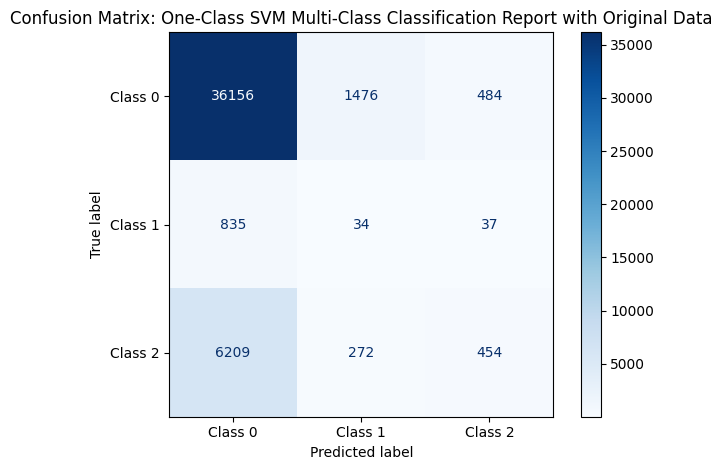

In [31]:
cm = confusion_matrix(y_test, predictions, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: One-Class SVM Multi-Class Classification Report with Original Data")
plt.grid(False)
plt.tight_layout()
plt.show()